In [1]:
import os
import sys
from nltk.corpus import stopwords
import re
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

22/04/13 14:55:28 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/13 14:55:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/13 14:55:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/13 14:55:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/04/13 14:55:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/04/13 14:55:29 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/04/13 14:55:29 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [4]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))

In [5]:
classics.show()

+--------------------+--------------------+--------------------+
|                  id|                type|                text|
+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|
|      THE GOVERNESS |                null|                null|
|                  OR| THE LITTLE FEMAL...|                null|
|   by Sarah Fielding|                null|                null|
|There lived in th...|   a gentlewoman who|                null|
|undertook the edu...|                null|                null|
|faithfully to dis...| by instructing t...|                null|
|             reading|             writing|             working|
|though her princi...|                null|                null|
|knowledge  to ren...|          and gentle|                kind|
|and affectionate ...|                null|                null|
|exact neatness in...| and a perfect ge...|                null|
|their whole carri...|   

In [6]:
import string

In [7]:
classics_df = classics.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
classics_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                  id|                type|                text|                line|
+--------------------+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|                   "|
|             reading|             writing|             working|             working|
|knowledge  to ren...|          and gentle|                kind|                kind|
|    This gentlewoman| whose name was T...| was the widow of...| was the widow of...|
|        Mrs. Teachum| though exceeding...|         yet thought|         yet thought|
|             desires| and did not seek...| she was resolved to| she was resolved to|
|would be prevaile...| great applicatio...|            when any|            when any|
|        reprehending| and that pretty ...| any girl that wa...| any girl that wa...|
|dignity and autho...| by her steady be...| that the g

In [8]:
classics = classics_df.rdd.map(lambda x : x['line']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [9]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [10]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [11]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/13 14:55:44 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/13 14:55:44 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [12]:
classics_df.printSchema()
classics_df.show()

root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)
 |-- line: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                  id|                type|                text|                line|
+--------------------+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|                   "|
|             reading|             writing|             working|             working|
|knowledge  to ren...|          and gentle|                kind|                kind|
|    This gentlewoman| whose name was T...| was the widow of...| was the widow of...|
|        Mrs. Teachum| though exceeding...|         yet thought|         yet thought|
|             desires| and did not seek...| she was resolved to| she was resolved to|
|would be prevaile...| great applicatio...|            when any|            wh

In [13]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 6, 7, 14, 19,...|[0.13822545808963...|
|    1|[3, 5, 8, 16, 23,...|[0.03753846329089...|
|    2|[15, 29, 69, 70, ...|[0.02835940144127...|
|    3|[2, 26, 17, 36, 3...|[0.05054303728204...|
|    4|[13, 32, 47, 77, ...|[0.03059554486949...|
|    5|[4, 11, 24, 45, 4...|[0.04338590701852...|
|    6|[1, 9, 20, 34, 51...|[0.06246624980396...|
|    7|[33, 38, 58, 64, ...|[0.01920596094636...|
|    8|[22, 25, 35, 43, ...|[0.02975916204335...|
|    9|[10, 12, 27, 21, ...|[0.03655045309831...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [14]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [15]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[0, 6, 7, 14, 19,...|[0.13822545808963...|[said, must, know...|
|    1|[3, 5, 8, 16, 23,...|[0.03753846329089...|[like, never, thi...|
|    2|[15, 29, 69, 70, ...|[0.02835940144127...|[thought, great, ...|
|    3|[2, 26, 17, 36, 3...|[0.05054303728204...|[could, take, mis...|
|    4|[13, 32, 47, 77, ...|[0.03059554486949...|[good, cried, loo...|
|    5|[4, 11, 24, 45, 4...|[0.04338590701852...|[little, much, te...|
|    6|[1, 9, 20, 34, 51...|[0.06246624980396...|[would, shall, ma...|
|    7|[33, 38, 58, 64, ...|[0.01920596094636...|[anne, eyes, tone...|
|    8|[22, 25, 35, 43, ...|[0.02975916204335...|[went, answered, ...|
|    9|[10, 12, 27, 21, ...|[0.03655045309831...|[though, looking,...|
+-----+--------------------+--------------------+--------------------+



In [16]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))
lda_topics_mapped = lda_topics_mapped.withColumn("termWeights", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))
lda_topics_mapped.show()

AnalysisException: Resolved attribute(s) topic_desc#190 missing from topic#183,termIndices#184,termWeights#185,topic_desc#214 in operator !Project [topic#183, termIndices#184, concat_ws( , topic_desc#190) AS termWeights#220, topic_desc#214]. Attribute(s) with the same name appear in the operation: topic_desc. Please check if the right attribute(s) are used.;
!Project [topic#183, termIndices#184, concat_ws( , topic_desc#190) AS termWeights#220, topic_desc#214]
+- Project [topic#183, termIndices#184, termWeights#185, concat_ws( , topic_desc#190) AS topic_desc#214]
   +- Project [topic#183, termIndices#184, termWeights#185, map_termID_to_Word(termIndices#184) AS topic_desc#190]
      +- Project [_1#177 AS topic#183, _2#178 AS termIndices#184, _3#179 AS termWeights#185]
         +- LocalRelation [_1#177, _2#178, _3#179]


In [17]:
df = ldatopics_mapped.withColumn("new", f.arrays_zip("topic_desc", "termWeights"))\
       .withColumn("new", f.explode("new")) \
        .select("topic", f.col("new.topic_desc").alias("words"), f.col("new.termWeights").alias("termWeights"))

In [18]:
df.show()

+-----+------+--------------------+
|topic| words|         termWeights|
+-----+------+--------------------+
|    0|  said| 0.13822545808963904|
|    0|  must|0.035977166950471665|
|    0|  know| 0.03279702491456204|
|    0|  come| 0.02824186126353003|
|    0|rather|0.024187158600538553|
|    0|  came| 0.01790690350509636|
|    0|  last|0.015414907138807181|
|    0|  want|0.014575836649503073|
|    0|  knew|0.014229469342859393|
|    0|  sure|0.012622165525551213|
|    1|  like| 0.03753846329089002|
|    1| never| 0.03280665938324792|
|    1| think| 0.02909734405222777|
|    1| might|0.026857113167742263|
|    1| quite|0.021669471341355044|
|    1|  look| 0.01991160317698011|
|    1| young|0.017498026037329684|
|    1|  time| 0.01724234651840877|
|    1|  long|0.017071651193048275|
|    1|  well|0.015239985955537374|
+-----+------+--------------------+
only showing top 20 rows



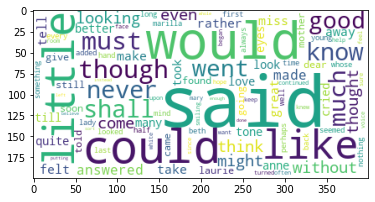

In [19]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*df.select(F.create_map('words', 'termWeights')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
